## hypothesis success: people and ratings

Run this code to get the "Christmas wreath" graph

Each vertices (node) represents a movie.  
Each edge (line connection) represents a person that worked in both the connected movies.  
Green vertices represent movies which average rating is 7 or higher.  
Red vertices represent movies which average rating is 3 or lower.

In [1]:
# libraries
library(igraph)
library(plyr)
library(ggplot2)


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [2]:
options(repr.plot.width=20, repr.plot.height=18, repr.plot.res = 200)

In [3]:
merged = read.delim('./../dataset/merge_basics_ratings_crew.tsv',header=TRUE)

In [4]:
head(merged)

,tconst,titleType,isAdult,startYear,runtimeMinutes,genre1,genre2,genre3,averageRating,numVotes,n_directors,n_writers
,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<int>
1,tt0000001,short,0,1894,1,Documentary,Short,0,5.6,1654,1,1
2,tt0000002,short,0,1892,5,Animation,Short,0,6.1,199,1,1
3,tt0000003,short,0,1892,4,Animation,Comedy,Romance,6.5,1366,1,1
4,tt0000004,short,0,1892,12,Animation,Short,0,6.2,121,1,1
5,tt0000005,short,0,1893,1,Comedy,Short,0,6.2,2149,1,1
6,tt0000006,short,0,1894,1,Short,0,0,5.3,115,1,1


In [50]:
# filtered name basics containing only actors and actresses
#names = read.csv('./../dataset/name_basics_actors_actresses.csv',header=TRUE)

# filtered name basics containing only actors, actresses, director and writers
names = read.csv('./../dataset/name_basics_actors_actresses_director_writer_or.csv',header=TRUE)

In [51]:
head(names)

,nconst,primaryName,primaryProfession1,primaryProfession2,primaryProfession3,knownForTitles1,knownForTitles2,knownForTitles3,knownForTitles4,isDead
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
1,nm0000001,Fred Astaire,soundtrack,actor,miscellaneous,tt0053137,tt0072308,tt0050419,tt0031983,1
2,nm0000002,Lauren Bacall,actress,soundtrack,0,tt0117057,tt0071877,tt0038355,tt0037382,1
3,nm0000003,Brigitte Bardot,actress,soundtrack,music_department,tt0049189,tt0054452,tt0057345,tt0059956,0
4,nm0000004,John Belushi,actor,soundtrack,writer,tt0072562,tt0077975,tt0078723,tt0080455,1
5,nm0000005,Ingmar Bergman,writer,director,actor,tt0050986,tt0060827,tt0083922,tt0050976,1
6,nm0000006,Ingrid Bergman,actress,soundtrack,producer,tt0034583,tt0036855,tt0038787,tt0038109,1


In [52]:
df = data.frame(nconst=rep(names$nconst, times=4), knownForTitles=NA)

In [53]:
knownForTitles = c()
for( col in names[,6:9]){
   col=as.vector(col)
   knownForTitles = c(knownForTitles, col)
}
df$knownForTitles = knownForTitles
df$knownForTitles = factor(df$knownForTitles)

# order by movie
ordered_df = df[order(df$knownForTitles),]

# remove those columns
cleaned_df = ordered_df[ordered_df$knownForTitles!=0,]
cleaned_df$knownForTitles = factor(cleaned_df$knownForTitles)

In [54]:
freq_titles_df = count(cleaned_df, "knownForTitles")
df_less10 = cleaned_df[cleaned_df$knownForTitles %in% freq_titles_df[freq_titles_df$freq<=10,]$knownForTitles, ]
df_less10$knownForTitles = factor(df_less10$knownForTitles)

In [55]:
# very bad and very good
lower_3_higher_7 = merged[merged$averageRating <=3 | merged$averageRating >=7, ]

In [56]:
df10_l3_h7 = df_less10[df_less10$knownForTitles %in% lower_3_higher_7$tconst, ]
df10_l3_h7$knownForTitles = factor(df10_l3_h7$knownForTitles) 

In [57]:
split_person_df10_l3_h7 = split(df10_l3_h7, df10_l3_h7$nconst)
length(split_person_df10_l3_h7)

[1] 1119488

In [73]:
comb_matrix_person_df10_l3_h7 = c()
isolated_movies = c() # list of movies that had persons that only have 1 movie that are known for. This leads to a movie node with no connections. Needs to be added later.
for( i in 1:length(split_person_df10_l3_h7)){
    len = length(split_person_df10_l3_h7[[i]][[2]])
    if(len > 1){ # does not consider movies that only one person is known for (messes with the structure)
        temp = combn(as.vector(split_person_df10_l3_h7[[i]][[2]]), 2)  # combinations without repetions with persons that worked in the same movie
                                                        # so we have the connections for the graph
        comb_matrix_person_df10_l3_h7 = cbind(comb_matrix_person_df10_l3_h7, temp)
    }
    else if(len == 1){
        isolated_movies = cbind(isolated_movies, as.vector(split_person_df10_l3_h7[[i]][[2]]))
    }
}

In [74]:
relations_person_df10_l3_h7 = data.frame(from=comb_matrix_person_df10_l3_h7[1,],
                        to=comb_matrix_person_df10_l3_h7[2,]
                        )
g_person_df10_l3_h7 = graph_from_data_frame(relations_person_df10_l3_h7, directed=FALSE)
g_person_df10_l3_h7_isolated = add_vertices(g_person_df10_l3_h7, length(isolated_movies), name=isolated_movies)

In [75]:
ratings_color = data.frame(tconst = lower_3_higher_7[lower_3_higher_7$tconst %in% df_less10$knownForTitles, ]$tconst, averageRating=lower_3_higher_7[lower_3_higher_7$tconst %in% df_less10$knownForTitles, ]$averageRating, color=NA)

In [76]:
ratings_color[ratings_color$averageRating <= 3, ]$color = "red" 
ratings_color[ratings_color$averageRating >= 7, ]$color = "darkolivegreen4"

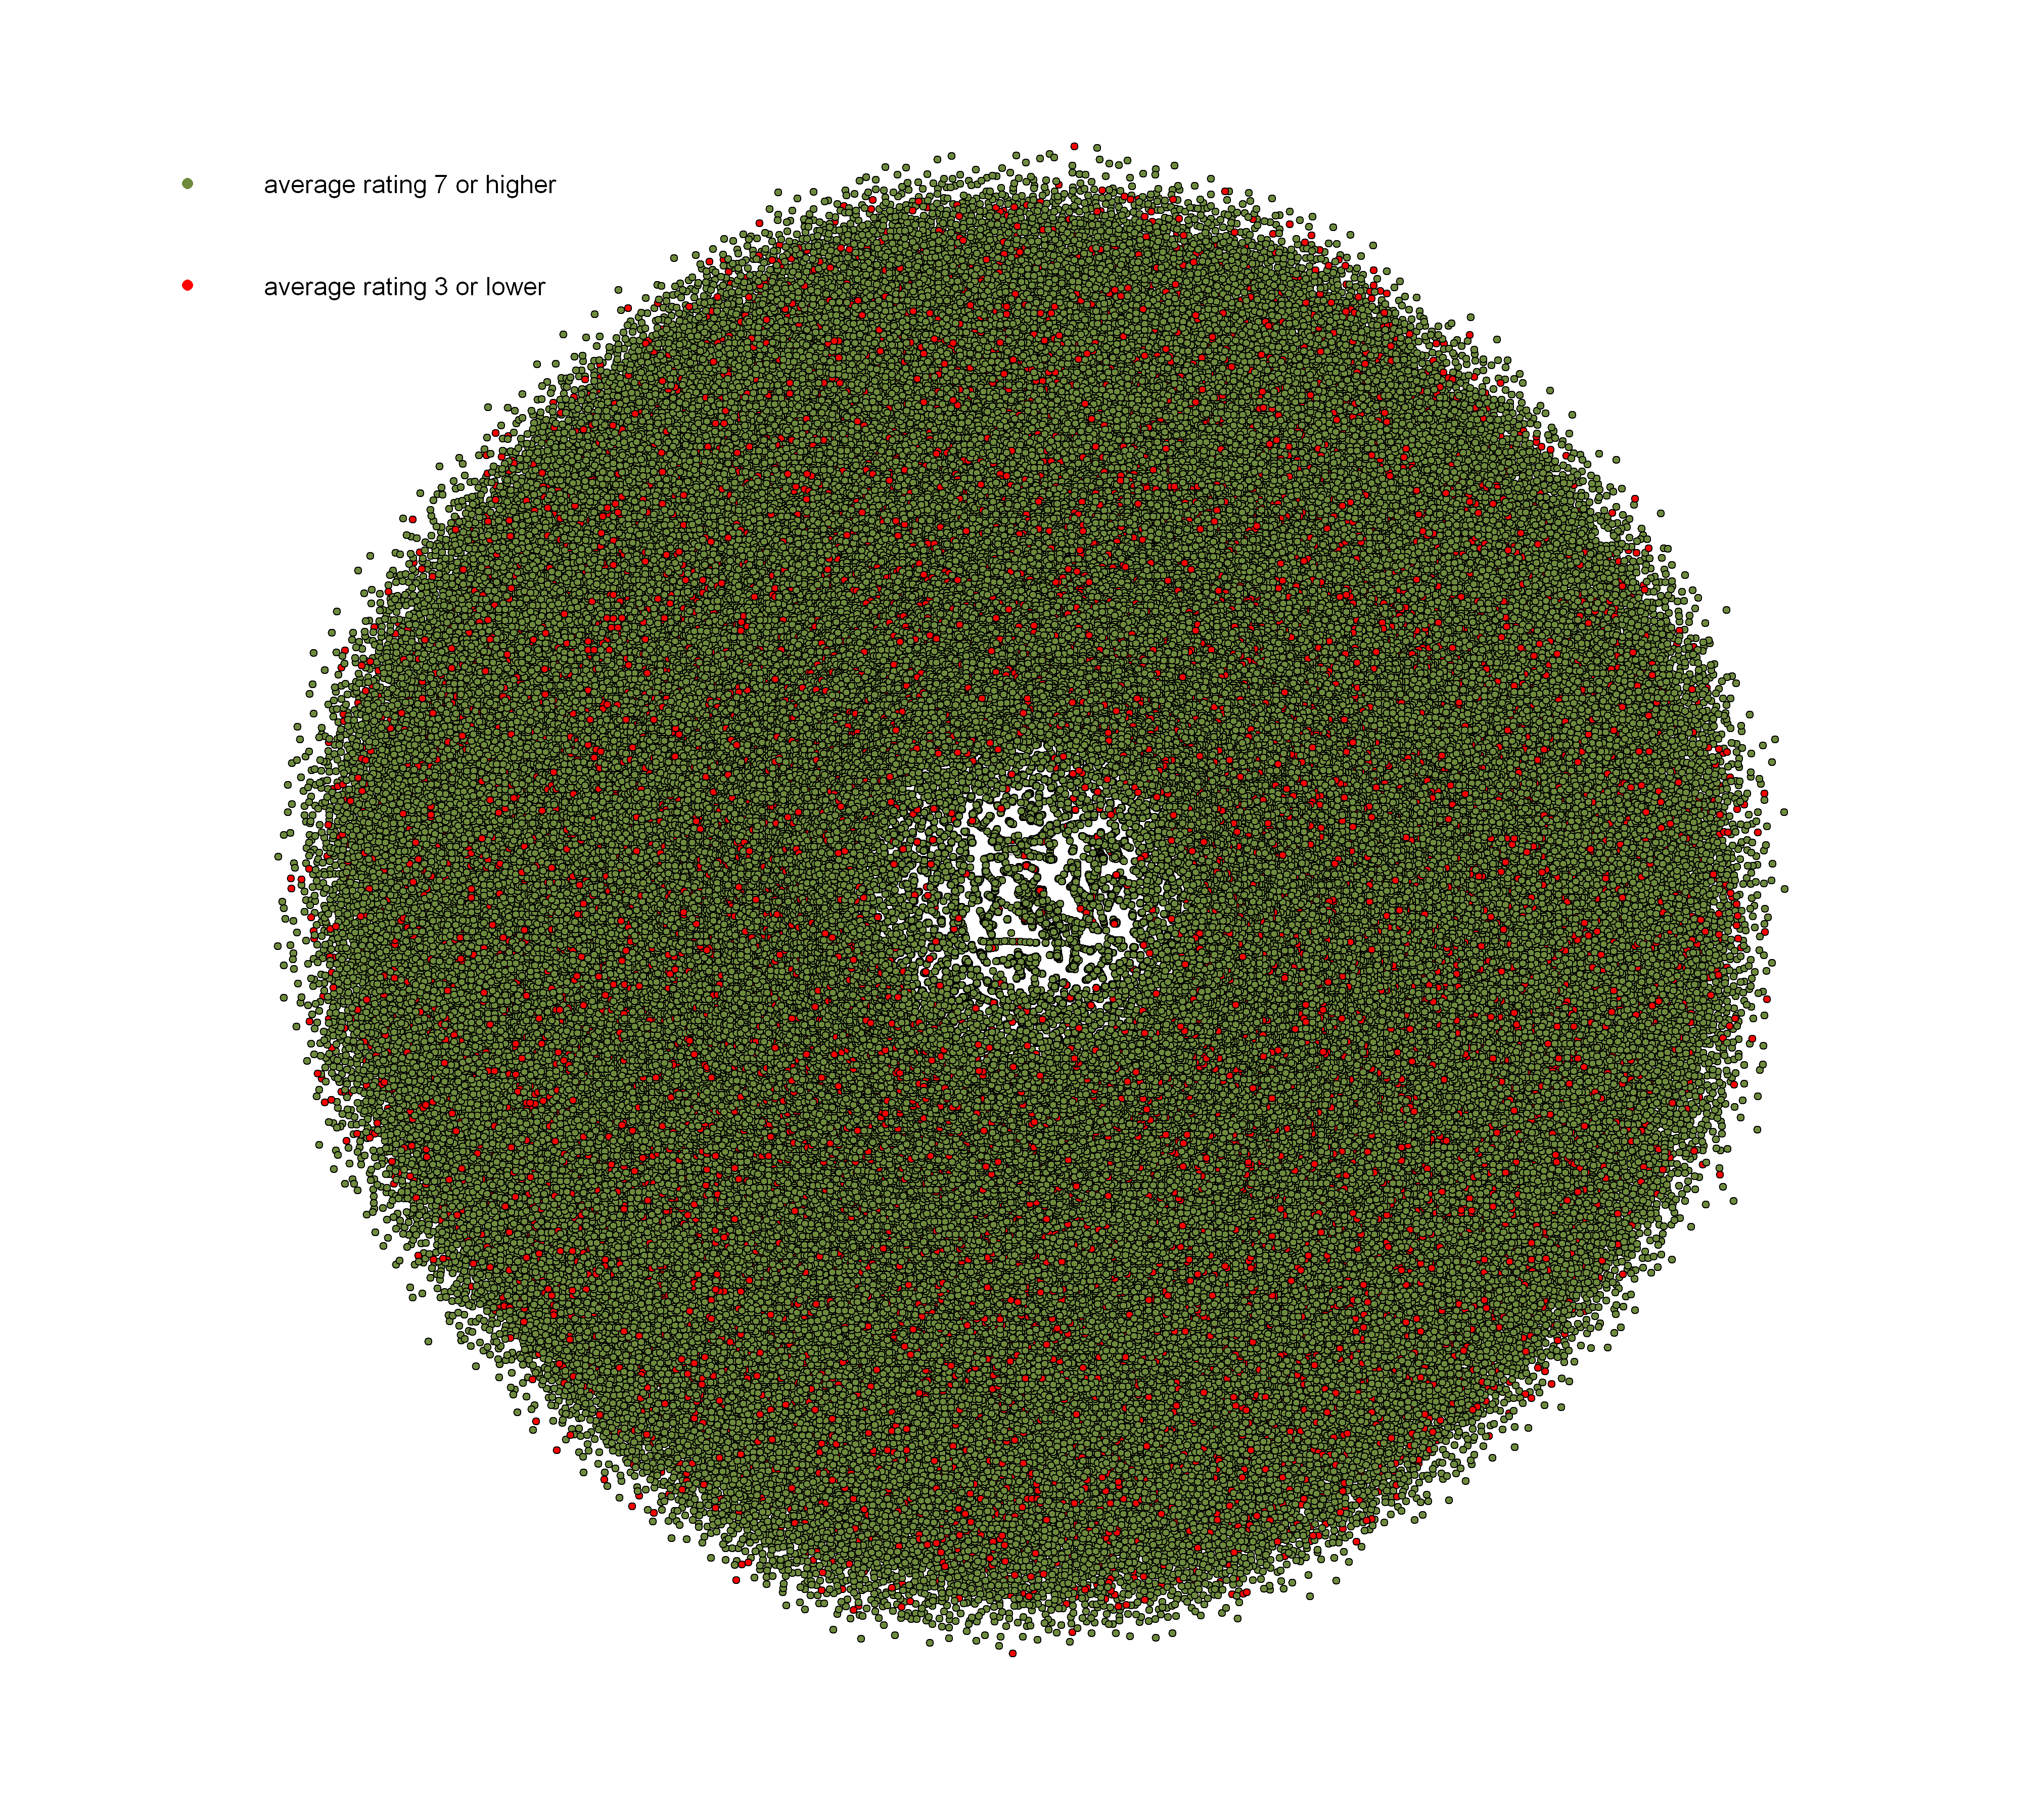

In [71]:
v_names_isolated = data.frame(tconst=V(g_person_df10_l3_h7_isolated)$name) # V(g_person_df10_l3_h7) is an igraph class, needs to be a data frame to merge
vertices_color_isolated = merge(v_names_isolated, ratings_color, all.x=TRUE)
V(g_person_df10_l3_h7_isolated)$color = vertices_color_isolated$color

#png("graph_df10_l3_h7.png", width = 1000, height = 1000)
plot(g_person_df10_l3_h7_isolated, vertex.size=1, vertex.label=NA)
legend('topleft',legend=c("average rating 7 or higher", "average rating 3 or lower"),col=unique(ratings_color$color), pch=16, cex=1.5, bty="n")
#dev.off()

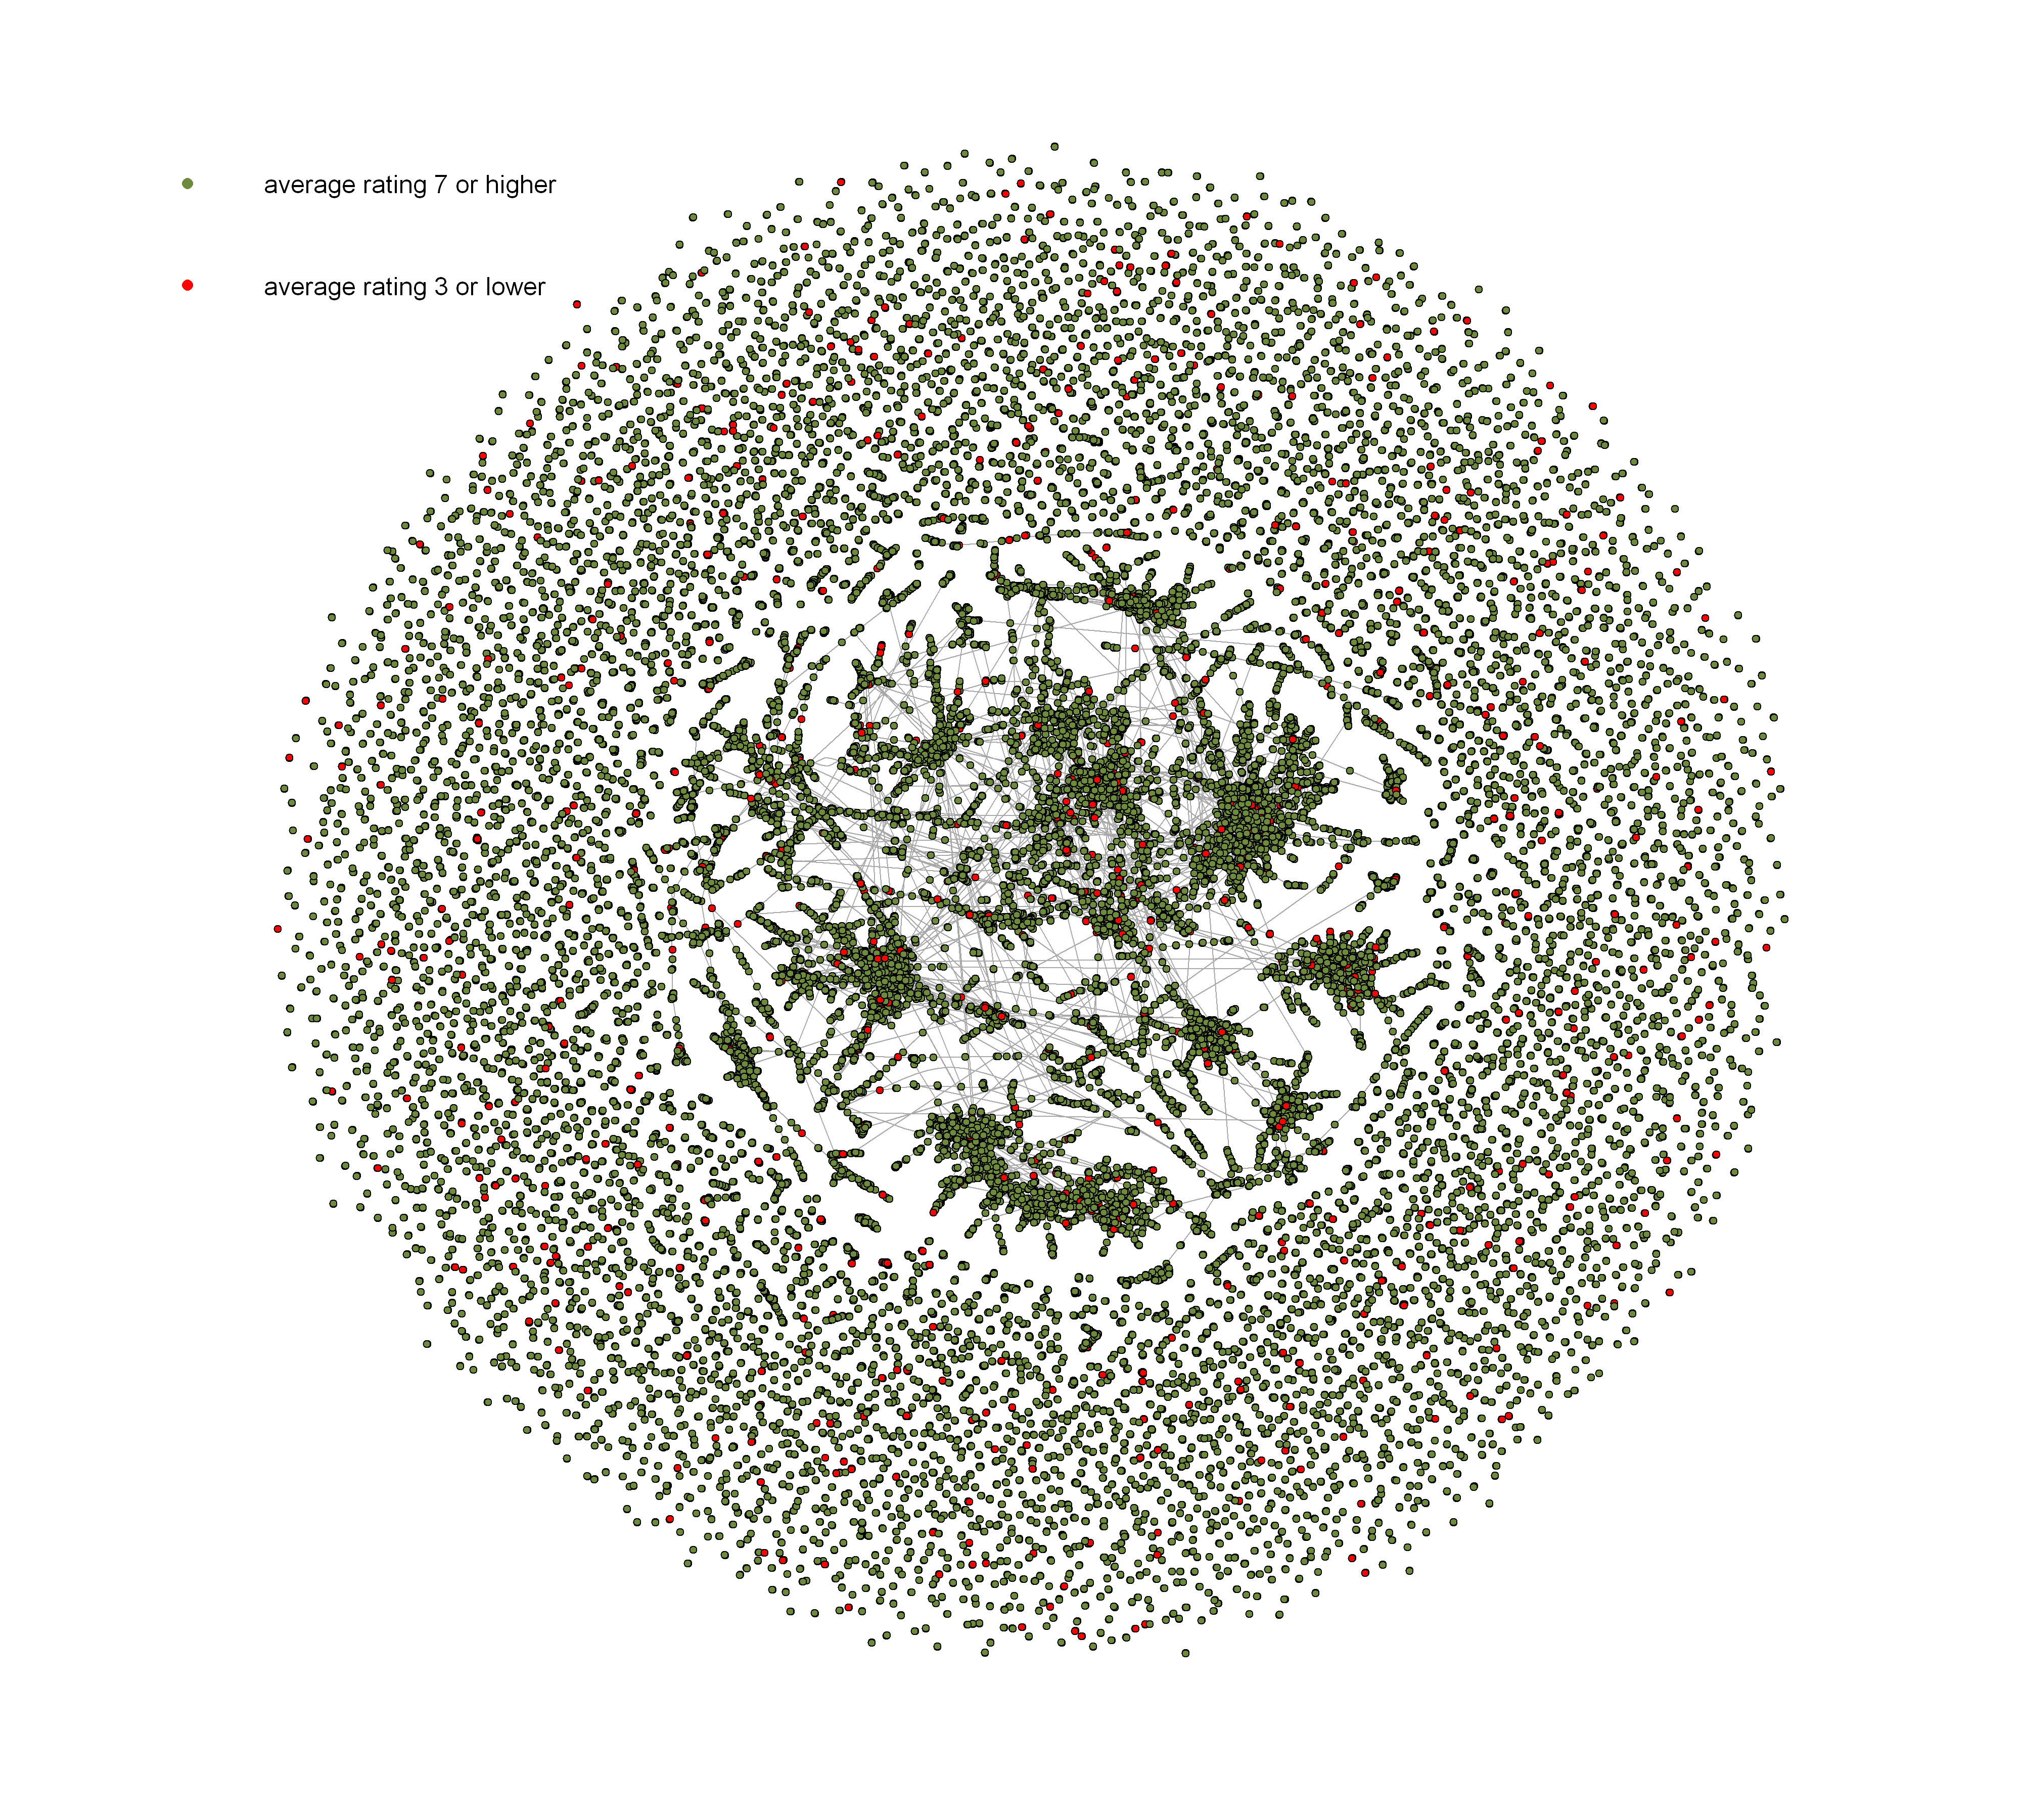

In [77]:
v_names = data.frame(tconst=V(g_person_df10_l3_h7)$name) # V(g_person_df10_l3_h7) is an igraph class, needs to be a data frame to merge
vertices_color = merge(v_names, ratings_color, all.x=TRUE)
V(g_person_df10_l3_h7)$color = vertices_color$color

#png("graph_df10_l3_h7.png", width = 1000, height = 1000)
plot(g_person_df10_l3_h7, vertex.size=1, vertex.label=NA)
legend('topleft',legend=c("average rating 7 or higher", "average rating 3 or lower"),col=unique(ratings_color$color), pch=16, cex=1.5, bty="n")
#dev.off()